In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
#  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
#    print(e)

40

In [5]:
file_name = '~/Data/kospi200f_809_0403.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2018-12-31'
test_start = '2019-01-02'
test_end = '2020-04-02'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble4'
channel = False

trans_day = 32

target_alpha = 100
future_day = 1
n_timestep = 20
time_interval = 1
input_size = 809
n_unit = 800
batch_size = 32
learning_rate = 0.0005
n_iteration = 10000

alpha = 0.5

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) / df.loc[i, target_column]) * target_alpha 

In [7]:
df['종가'].values[:20]

array([-3.55351171,  2.68747291,  0.67539046,  2.59958071, -0.89906007,
        1.56701031, -0.24360536, -1.62800163, -4.01323955, -4.43965517,
        3.15741994, -1.48666375, -0.71016423, -4.60438087,  0.51546392,
        3.07692308, -1.53776572,  0.04593477, -6.06060606,  0.63538612])

In [8]:
def loss_mean_square(model, input_data, output_data):
    logits = model(input_data, training=True)
    loss = tf.reduce_mean(tf.square(logits - tf.math.sign(output_data)))
    return loss

In [9]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [10]:
#@tf.function
def loss_fn_model1(m1, m2, train_x, train_y):
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(m1(train_x)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(targets), dtype=tf.float64)        
    #profits = 1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds
    
    loss1 = keras.losses.MSE(preds, updown)
    
    returns = [1.0]

    n = len(targets)
    for i in range(n):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []

        avg_return = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))

        model2_pred = tf.math.abs(tf.cast(m2(state, training=False)[0, 0], dtype=tf.float64))
        returns.append(model2_pred)
        
    avg_return = tf.math.reduce_prod(returns)**(1/n)
    std_return = tf.math.reduce_std(returns)
    if std_return == 0: 
        sharp_ratio = avg_return
    else: 
        sharp_ratio = avg_return / std_return
    return loss1 - alpha*sharp_ratio


In [11]:
#@tf.function
def loss_fn_model1_x(m1, m2, train_x, train_y):
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)   
    preds = tf.reshape(m1(train_x)[:, -1, 0], [-1])
    profits = tf.convert_to_tensor(rates, dtype=tf.float64)*preds + 1 
    
    loss1 = tf.keras.losses.MSE(updqwn, preds) 
    
    n = len(targets)    
    losses = []
    returns = [1.0]
    
    for i in range(n):
       
        random_preds = []
        values = []
       
        for j in range(10):
            # 원 modle1 값 주변을 random search for 최대 평균 수익률
            state = []

            pred  = tf.cast(tf.random.normal((), mean=preds[i], stddev=0.1), dtype=tf.float64)
            profit = tf.convert_to_tensor(rates[i], dtype=tf.float64)*pred + 1 
            random_preds.append(pred)

            avg_return = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
            state.append(avg_return)
            state.append(tf.math.reduce_std(returns))
            state.append((n - i) / n)
            state.append(preds[i])
            state = np.array(state).reshape((1, 4))

            values.append(tf.cast(m2(state, training=False)[0, 0], dtype=tf.float64))
        
        max_val_idx = tf.math.argmax(values) 
        best_pred = tf.cast(random_preds[max_val_idx], dtype=tf.float64)
        profit = tf.convert_to_tensor(rates[i], dtype=tf.float64)*best_pred + 1 
        returns.append(profit)
                       
        losses.append(tf.math.sqrt(best_pred, preds[i]))

    return tf.math.reduce_mean(losses)    


In [12]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = tf.cast(targets / 100, dtype=tf.float64)
    preds = tf.reshape(m1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []        
        # 현재 까지의 실재 수익률을 random 수익률로 저장
        for k in range(i+1):
            random_rates.append(rates[k])
            
        # 현재 시점 이후, 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=rates[k], stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns_past))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)

    return tf.math.reduce_sum(losses)

In [13]:
#@tf.function
def test(m1, m2, test_x, test_y):    
    targets = tf.reshape(test_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(m1(test_x)[:, -1, 0], [-1])
    
    n = len(targets)    
    best_preds = []
    returns = [1.0]
    
    for i in range(n):
       
        random_preds = []
        values = []
       
        for j in range(10):
            # 원 modle1 값 주변을 random search for 최대 평균 수익률
            state = []

            pred  = tf.cast(tf.random.normal((), mean=preds[i], stddev=0.1), dtype=tf.float64)
            if pred > 1: pred = 1
            elif pred < -1: pred = -1    
            profit = tf.convert_to_tensor(rates[i], dtype=tf.float64)*pred + 1 
            random_preds.append(pred)

            avg_return = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
            state.append(avg_return)
            state.append(tf.math.reduce_std(returns))
            state.append((n - i) / n)
            state.append(preds[i])
            state = np.array(state).reshape((1, 4))

            values.append(tf.cast(m2(state, training=False)[0, 0], dtype=tf.float64))
        
        max_val_idx = tf.math.argmax(values) 
        best_pred = tf.cast(random_preds[max_val_idx], dtype=tf.float64)
        profit = tf.convert_to_tensor(rates[i], dtype=tf.float64)*best_pred + 1 
        returns.append(profit)
                       
        best_preds.append(best_pred)

    return best_preds    

In [14]:
#@tf.function
def test_model2(m1, m2, test_x, test_y):
    
    targets = tf.reshape(test_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.cast(tf.reshape(m1(test_x, training=False)[:, -1, 0], [-1]), dtype=tf.float64)
    #updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + rates * preds
    
    returns = [1.0]
    inv_rate = []
    
    n = len(targets)
    for i in range(n):
        
        # average_return, std of returns, remaining days, preds[0] 
        state = np.zeros(4)
        
        state[0] = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state[1] = tf.math.reduce_std(returns)
        state[2] = (n - i) / n        
        state[3] = preds[i]
        state = state.reshape(1, 4)
        
        model2_pred = np.array(m2(state, training=False))[0, 0]
        inv_rate.append(model2_pred)
        returns.append(profits[i])

    return inv_rate

In [15]:
#@tf.function
def gradient1(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, model2, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [16]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM_tanh(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.DenseLayer_linear(4, 10)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

#    model.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
            
#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

In [17]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:-future_day]
    train_y = train_y[:-future_day]    
    
    #global_step = tf.train.get_or_create_global_step()
    global_step = tf.Variable(0, trainable=False)
    #lr_decay = tf.train.exponential_decay(learning_rate, global_step,
    #                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
    lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
    epochs = len(train_y)
    for iteration in range(epochs):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        #noise = 2*np.random.randn(batch_size,n_timestep,1)
        #batch_output = batch_output+noise
        #batch_input = encoder(train_input[idx])
        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        gradients1 = gradient1(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        if iteration % 100 == 0:
            #test_MSE = model.evaluate(test_x, test_y)
            prediction = model1.predict(test_x)
            prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
            print('prediction_MSE =', prediction_MSE)

        if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
            break
    epochs -= epochs / 5
    if epochs <= 0: epochs = 1000

    print('test dates ' + current_test_start + "~" + current_test_end)
    
    #단순 예측
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    prediction_MSE = sum(test_y[:, -1, 0] - prediction[:, -1, 0]).reshape((-1))**2/len(test_y)
    print('prediction_MSE =', prediction_MSE)

    #calculate accuracy
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('accuracy = ', accu)

    prediction2 = test(model1, model2, test_x, test_y)    
    
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_start = df.loc[prepro.date_to_index(df, current_train_start) + trans_day, 'date']
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for

prediction_MSE = 2.25
step :  10
Training process is stopped early....
test dates 2020-01-16~2020-03-03
prediction_MSE = [5.1737578]
accuracy =  tf.Tensor(0.4375, shape=(), dtype=float64)
prediction_MSE = 2.0
prediction_MSE = 2.3636363636363638
prediction_MSE = 1.8181818181818181
prediction_MSE = 1.6363636363636365
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.0
prediction_MSE = 1.8181818181818181
prediction_MSE = 2.0
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.0
prediction_MSE = 1.8181818181818181
prediction_MSE = 1.8181818181818181
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.0
prediction_MSE = 2.3636363636363638
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
prediction_MSE = 2.1818181818181817
step :  11
Training pro

In [18]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [19]:
t2

array([-0.89441401,  0.94391412, -0.02879511,  1.        ,  0.27012888,
       -0.76586282, -0.41363558,  0.56954467,  0.59135133, -0.92907917,
        0.34431463, -0.05470644, -0.00536788,  0.70018816,  1.        ,
       -0.43568978,  0.68720961,  0.90191239,  0.90681392,  0.79666692,
        0.58142626, -0.41216683,  0.71222788,  0.11065135,  0.10046364,
       -0.49150699, -0.72808057, -0.77157766,  0.62004524, -1.        ,
        0.81958765, -0.03915159, -0.2126212 , -0.48525214,  0.17359091,
        1.        , -0.89823419,  0.48230857, -0.79905224,  0.23998848,
        1.        ,  0.99682158, -0.86015964, -1.        ,  1.        ,
        0.84854549, -1.        ,  1.        ,  0.85730457,  1.        ,
        0.9872545 , -0.80172765, -0.18080014,  1.        ,  0.17987745,
        0.64005947, -0.61787122,  1.        ,  0.7825675 ,  1.        ,
        0.89670479, -0.41704363,  0.55154526,  0.32852435,  1.        ,
        1.        , -0.64205843, -0.9467501 ,  0.78702539, -0.05

In [20]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [21]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.4935483870967742, shape=(), dtype=float64)


In [22]:
updown.shape

(310,)

In [23]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [24]:
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [25]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble4_kospi200f_reinfo_809_20_1_1_0.497
MSE : 3.0747 , Accuracy : 0.497
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble4_kospi200f_reinfo_809_20_1_1_0.497/assets


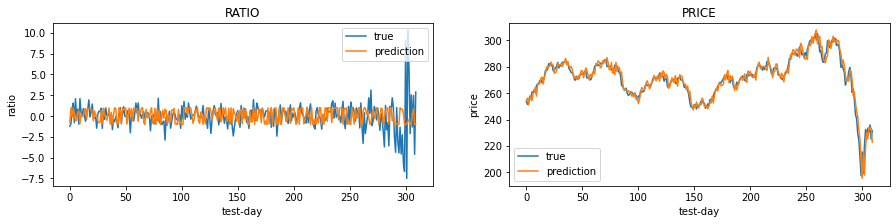

In [26]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,n_timestep,time_interval)
result.save_visualization()
result.save_model(model2)

In [ ]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
